In [1]:
from datasets import load_dataset
import torch
import tiktoken

# Setup device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

/Users/shwetank/code/makemore-utils-nbs/makemore/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Hyperparams
batch_size = 32
block_size = 128
emb_dim = 384
num_heads = 6
num_layers = 4
dropout = 0.2
linear_scaleup = 4
temperature = 1

# Optimization loop parameters
n_epochs = 100
eval_interval =10

In [3]:
# Load WikiText-103 dataset
dataset = load_dataset("wikitext", "wikitext-103-raw-v1")
tokenizer = tiktoken.get_encoding("cl100k_base")

In [4]:
def preprocess_dataset(dataset, tokenizer, block_length=128):
    dataset_string = ' '.join(dataset['text'])
    tokenized_dataset = tokenizer.encode(dataset_string)
    return tokenized_dataset

In [5]:
# train_dataset = preprocess_dataset(dataset['train'],tokenizer)
# val_dataset = preprocess_dataset(dataset['validation'],tokenizer)
# test_dataset = preprocess_dataset(dataset['test'],tokenizer)
# print(len(train_dataset), len(val_dataset), len(test_dataset))

In [6]:
# Load WikiText-103 dataset
dataset = load_dataset("wikitext", "wikitext-103-raw-v1")
tokenized_dataset = {}

# Create tokenized text blobs
train_tokens = preprocess_dataset(dataset['train'],tokenizer)
val_tokens = preprocess_dataset(dataset['validation'],tokenizer)
test_tokens = preprocess_dataset(dataset['test'],tokenizer)
print(len(train_tokens), len(val_tokens), len(test_tokens))

# Convert to tokenized text tensors
train_tensor = torch.squeeze(torch.tensor(train_tokens, dtype=torch.long))
val_tensor = torch.tensor(val_tokens, dtype=torch.long)
test_tensor = torch.tensor(test_tokens, dtype=torch.long)
print(f"Number of training tokens: {train_tensor.shape}, validation tokens: {val_tensor.shape}, test tokens: {test_tensor.shape}")

121361219 255437 292057
Number of training tokens: torch.Size([121361219]), validation tokens: torch.Size([255437]), test tokens: torch.Size([292057])


In [7]:
from torch.utils.data import Dataset
import torch

class WikiData(Dataset):
    def __init__(self, dataset: Dataset, block_size: int=128, batch_size: int=64):
        self.block_size = block_size
        self.batch_size = batch_size
        self.dataset = dataset
        

    def __len__(self) -> int:
        return self.block_size

    def __getitem__(self, idx: int) -> tuple[torch.tensor, torch.tensor]:
        x = torch.zeros((self.batch_size,self.block_size + 1), dtype=torch.long)
        y = torch.zeros((self.batch_size,self.block_size + 1), dtype=torch.long)
        # print(idx)
        x = self.dataset[idx:idx+self.block_size]
        y = self.dataset[idx+1:idx+self.block_size+1]
        return x.to(device), y.to(device)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Feedforward(nn.Module):
    def __init__(self,emb_dim,dropout) -> None:
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, linear_scaleup * emb_dim),
            nn.ReLU(),
            nn.Linear(linear_scaleup * emb_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        return self.ff(x)

class Block(nn.Module):
    def __init__(self, emb_dim, num_heads, dropout) -> None:
        super().__init__()
        self.head_size = emb_dim // num_heads
        self.sa_head = nn.MultiheadAttention(emb_dim, num_heads, dropout)
        self.ff = Feedforward(emb_dim, dropout)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x, targets=None):
        x = self.ln1(x)
        sa_out, _ = self.sa_head(x,x,x)
        x = x + sa_out
        x = x + self.ff(self.ln2(x))
        return x


class Xformer(nn.Module):
    def __init__(self, emb_dim, num_heads, num_layers, dropout): 
        super().__init__()
        self.tok_emb = nn.Embedding(tokenizer.n_vocab, emb_dim)
        self.pos_emb = nn.Embedding(tokenizer.n_vocab, emb_dim)
        # self.blocks = nn.Sequential(
        #     Block(emb_dim, num_heads, dropout), 
        #     Block(emb_dim, num_heads, dropout),
        #     Block(emb_dim, num_heads, dropout),
        #     Block(emb_dim, num_heads, dropout), 
        #     # Block(emb_dim, num_heads, dropout),
        #     # Block(emb_dim, num_heads, dropout),
        #     nn.LayerNorm(emb_dim)
        # ) 
        blocks = []
        for _ in range(num_layers):
            blocks.append(Block(emb_dim, num_heads, dropout))
        
        self.blocks = nn.Sequential(*blocks, nn.LayerNorm(emb_dim))
        self.lm_head = nn.Linear(emb_dim, tokenizer.n_vocab)

    def forward(self, x, targets=None):
        x = self.tok_emb(x) + self.pos_emb(x)
        x = self.blocks(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return(logits,loss)

In [9]:
## Get dataloader for train and  val datasets from training and test data
from torch.utils.data import DataLoader
train_data_obj = WikiData(train_tensor, block_size=block_size)
val_data_obj = WikiData(val_tensor, block_size=block_size)
train_dataloader = DataLoader(train_data_obj, batch_size=1)
val_dataloader = DataLoader(val_data_obj, batch_size=1)

In [10]:
# Single test run
from torch.optim import Adam
xb, yb = next(iter(train_dataloader))
print(xb.shape, yb.shape)
model = Xformer(emb_dim, num_heads, num_layers, dropout).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
logits, loss = model(xb,yb)
print(loss)

torch.Size([1, 128]) torch.Size([1, 128])
tensor(11.6413, device='mps:0', grad_fn=<NllLossBackward0>)


In [11]:
from utils import get_model_size
get_model_size(model)

122718005

Text(0, 0.5, 'Loss')

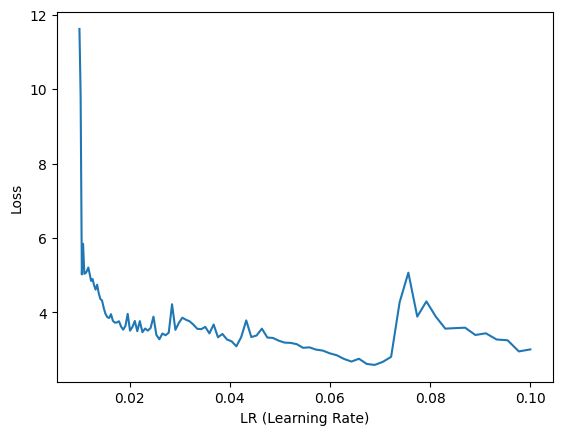

In [12]:
# ## Optimal lr sweep
from utils import get_lr_loss
import matplotlib.pyplot as plt
num_epochs = 100
lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, num_epochs, device, -2, -1)
plt.plot(lri, lossi)
# Add labels to the x-axis and y-axis
plt.xlabel('LR (Learning Rate)')
plt.ylabel('Loss')

In [13]:
train_dataloader = DataLoader(train_data_obj, batch_size=batch_size)
val_dataloader = DataLoader(val_data_obj, batch_size=batch_size)
tr_loss = []
vl_loss = []

In [14]:
from utils import evaluate_loss
lr = 0.01
optimizer = Adam(model.parameters(), lr=lr)
for steps in range(100):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, val_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    vl_loss.append(te_lossi)
    # print(loss.item())

    if steps % eval_interval-1 == 0:
        print('ltr: ', tr_lossi, 'lte: ', te_lossi, 'single shot loss:', loss.item())

8.550146102905273
5.40288782119751
ltr:  7.742373466491699 lte:  13.392343521118164 single shot loss: 5.40288782119751
7.628645420074463
6.652060031890869
4.883609771728516
4.741697311401367
4.680291175842285
4.625398635864258
4.582026958465576
4.5428266525268555
4.480504512786865
4.42928409576416
ltr:  4.351443767547607 lte:  11.190017700195312 single shot loss: 4.42928409576416
4.384407997131348
4.340149879455566
4.358789443969727
4.353360652923584
4.348776817321777
4.344067573547363
4.345567226409912
4.331995964050293
4.322419166564941
4.302818298339844
ltr:  4.25332498550415 lte:  14.040922164916992 single shot loss: 4.302818298339844
4.302260875701904
4.298330307006836
4.281959056854248
4.260782241821289
4.23151969909668
4.208183765411377
4.1749958992004395
4.155423641204834
4.139967918395996
4.126089096069336
ltr:  3.947361469268799 lte:  14.579264640808105 single shot loss: 4.126089096069336
4.084786415100098
4.079926490783691
4.082832336425781
4.094893455505371
4.07940721511840

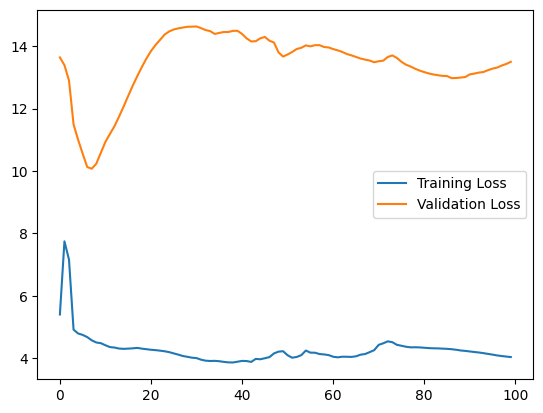

training loss:  4.1209
validation loss:  13.269


In [19]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss, label='Training Loss')
plt.plot(vl_loss, label='Validation Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-10:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(vl_loss[-10:]))).item(),4))

In [20]:
@torch.no_grad()
def generate(model, max_new_tokens=block_size, batch_size=batch_size, temperature=temperature):
    idx = torch.zeros((batch_size, 1), dtype=torch.long).to(device)
    for _ in range(max_new_tokens):
        # print('idx shape:',idx.shape)
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        idx_cond = idx_cond.to(device)
        logits, _ = model(idx_cond)
        # Pick only the logits from most recent time step. Karpathy also does a divide by temp?
        # This is just Platt scaling which makes the various Softmax curves closes adding more randomness
        # see scratch.ipynb. https://en.wikipedia.org/wiki/Platt_scaling
        logits = logits[:,-1,:]/temperature
        probs = F.softmax(logits, dim=-1)
        # print('prob dist:',probs)
        idx_next = torch.multinomial(probs, num_samples=1)
        # print('idx_next shape:',idx_next.shape)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [21]:
X_samp = generate(model, block_size, 1, temperature).tolist()

In [22]:
for row in X_samp:
    print(tokenizer.decode(row))

! � the .ria videoy , time time@ . story serving " the game . playing III is201 outside story (yュ of tactical Portabley fusion game1 tacticaly the . Japaneseria ( in to , same fusion ,アリ @リ no Japanese videoision Sen3キ as referredリ . ( Valk firstの Sen real playing same , ) fusion�ア fusion first unit parallely ( Portable tactical and@ュ @ュ ( Name by the in referred referredria� referred-yriay3 Valk @ュ as they Portable�- as Japan andュ referred , for parallel outside as the3 Valk� of.V PlayStation
